# Transfer_learning&Dropouts
In this lab you will work through transfer learning using the Inception (version3) network for classifying cats and dogs.

---

### A. Transfer Learning
Model definition: the code cell below does the following:

1. Downloads the weights for a pre-trained inception network, and then instantiates a new instance of it using those weights.
2. Selects one of the pre-trained convolutional layers as the last layer for our new model to take as input.

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# 1. downloads the weights for a pre-trained inception
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

# Uncomment the code below to see the (huge) model summary  
pre_trained_model.summary()

# 2. 
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape) #(None, 7, 7, 768)
last_output = last_layer.output

--2019-11-11 03:43:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  18.5MB/s    in 4.5s    

2019-11-11 03:43:32 (18.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i


### Adding layers and compiling model
3. Add a fully connected layer to the pre-trained layers that have been defined as input to our model

In [0]:
from tensorflow.keras.optimizers import RMSprop

# 3.1 Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# 3.2 Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)
# For Part C: (Do this after completing 9) 10. Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# 3.3 Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)
model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


### Data preparation
4. Download cats vs dogs data

In [7]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# For Part B: (Do this after completing 6) 7. Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
    ) 

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2019-11-11 03:57:20--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   234MB/s    in 0.3s    

2019-11-11 03:57:20 (234 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
5. Train the model consisting of pre-trained layers from Inception v3 and new layers defined in 3.

In [12]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
Epoch 1/20
100/100 - 26s - loss: 0.4858 - acc: 0.7685 - val_loss: 0.3026 - val_acc: 0.9050
Epoch 2/20
Epoch 1/20
100/100 - 23s - loss: 0.3276 - acc: 0.8555 - val_loss: 0.3870 - val_acc: 0.9110
Epoch 3/20
Epoch 1/20
100/100 - 21s - loss: 0.3153 - acc: 0.8700 - val_loss: 0.4556 - val_acc: 0.9140
Epoch 4/20
Epoch 1/20
100/100 - 20s - loss: 0.2781 - acc: 0.8880 - val_loss: 0.7022 - val_acc: 0.9000
Epoch 5/20
Epoch 1/20
100/100 - 21s - loss: 0.2715 - acc: 0.8950 - val_loss: 0.3139 - val_acc: 0.9470
Epoch 6/20
Epoch 1/20
100/100 - 21s - loss: 0.2609 - acc: 0.8980 - val_loss: 0.3758 - val_acc: 0.9390
Epoch 7/20
Epoch 1/20
100/100 - 22s - loss: 0.2347 - acc: 0.9125 - val_loss: 0.4557 - val_acc: 0.9360
Epoch 8/20
Epoch 1/20
100/100 - 21s - loss: 0.2627 - acc: 0.8990 - val_loss: 0.2901 - val_acc: 0.9560
Epoch 9/20
Epoch 1/20
100/100 - 20s - loss: 0.2183 - acc: 0.9130 - val_loss: 0.3923 - val_acc: 0.9540
Epoch 10/20
Epoch 1/20
100/100 - 22s - loss: 0.2226 - acc: 0.9080 - val_loss: 0.28

### Model performance
6, 9, 11. Plot the graph of the training and validation accuracies

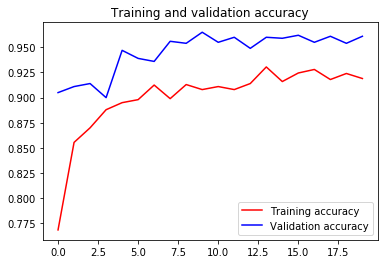

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()